# Image recognition
## Task 2.2
---
Task di classificazione di opere d'arte su 18 classi facenti riferimento a movimenti artistici di appartenenza.

## Importazione delle librerie

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from shutil import copyfile
from time import time
import zipfile

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import resnet50, inception_resnet_v2, MobileNet, xception, densenet
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Average, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras
from keras.regularizers import l1, l2


### Definizione delle classi da classificare

In [7]:
classes = os.listdir('Pandora_18k')
random.seed(1)
classes.remove('.DS_Store')
classes

['AbstractArt',
 'Baroque',
 'Byzantin_Iconography',
 'Cubism',
 'Early_Renaissance',
 'Expressionism',
 'Fauvism',
 'High_Renaissance',
 'Impressionism',
 'NaiveArt',
 'Northern_Renaissance',
 'PopArt',
 'Post_Impressionism',
 'Realism',
 'Rococo',
 'Romanticism',
 'Surrealism',
 'Symbolism']

## Modello 1: Resnet50_basic

In [8]:
# Training set generator
train_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
train_generator_rb = train_datagen_rb.flow_from_directory(
        directory='./aug_train_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 13125 images belonging to 18 classes.


In [9]:
# Validate set generator
val_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
val_generator_rb = val_datagen_rb.flow_from_directory(
        directory='./aug_val_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4383 images belonging to 18 classes.


In [10]:
# Test set generator
test_datagen_rb = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_generator_rb = test_datagen_rb.flow_from_directory(
        directory='./aug_test_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4378 images belonging to 18 classes.


### Definzione e training Modello 1

In [11]:
# Download del modello pre-allenato
base_net1 = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net1.layers)*.8)
for layer in base_net1.layers[:limit]:
    layer.trainable = False

# Costruzione layer di specializzazione
x = base_net1.output
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
resnet_basic = Model(inputs=base_net1.input, outputs=pred)
resnet_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='best_weights_basic_resnet50_aug.h5', 
                          monitor='val_acc', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, 
                          mode='auto', 
                          period=1)
earlystop=EarlyStopping(monitor='val_acc', 
                        min_delta=0, 
                        patience=6, 
                        verbose=1, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=True)




In [ ]:
# Training del modello
resnet_basic.fit_generator(train_generator_rb, steps_per_epoch=len(train_generator_rb), 
                           epochs=50, callbacks=[bestmodel, earlystop], 
                           validation_data=val_generator_rb, 
                           validation_steps=len(val_generator_rb), 
                           verbose=1)

In [12]:
# Shortcut per caricare i pesi prodotti dal training precedente
resnet_basic.load_weights('best_weights_basic_resnet50_aug.h5')

### Valutazione Modello 1

In [13]:
# Estrazione true labels e generazione delle predizioni
y_test_rb = test_generator_rb.classes

y_dist_rb = resnet_basic.predict_generator(test_generator_rb, steps=len(test_generator_rb.filenames), verbose=1)
y_pred_rb = np.argmax(y_dist_rb, axis=1)

4378/4378 [==============================] - 73s 17ms/step


In [14]:
# Report
print(classification_report(y_test_rb, y_pred_rb))

              precision    recall  f1-score   support

           0       0.64      0.83      0.72       262
           1       0.49      0.36      0.41       230
           2       0.63      1.00      0.77       234
           3       0.61      0.67      0.64       297
           4       0.87      0.66      0.75       250
           5       0.29      0.52      0.37       234
           6       0.48      0.38      0.42       154
           7       0.67      0.69      0.68       209
           8       0.80      0.43      0.56       258
           9       0.77      0.35      0.49       231
          10       0.77      0.65      0.70       250
          11       0.98      0.30      0.46       273
          12       0.35      0.53      0.42       288
          13       0.76      0.39      0.51       322
          14       0.46      0.79      0.58       204
          15       0.43      0.57      0.49       220
          16       0.62      0.54      0.58       216
          17       0.53    

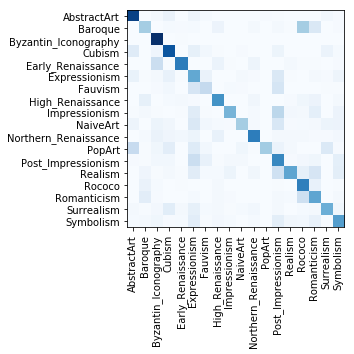

accuracy: 0.564870


In [15]:
# Matrice di confusione
cm = confusion_matrix(y_test_rb, y_pred_rb)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello 2: ResNet50_plus

In [17]:
# Training set generator
train_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
train_generator_rp = train_datagen_rp.flow_from_directory(
        directory='./aug_train_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 13125 images belonging to 18 classes.


In [18]:
# Validate set generator
val_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
val_generator_rp = val_datagen_rp.flow_from_directory(
        directory='./aug_val_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4383 images belonging to 18 classes.


In [19]:
# Test set generator
test_datagen_rp = kimage.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
test_generator_rp = test_datagen_rp.flow_from_directory(
        directory='./aug_test_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4378 images belonging to 18 classes.


### Definzione e training Modello 2


In [20]:
# Download del modello pre-allenato
base_net2 = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net2.layers)*.8)
for layer in base_net2.layers[:limit]:
    layer.trainable = False

# Costruzione dei layer di specializzazione
x = base_net2.output
x = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dense(256, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
x = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(x)
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
resnet_power = Model(inputs=base_net2.input, outputs=pred)
resnet_power.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='best_weights_power_resnet50_aug.h5', 
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, save_weights_only=True, 
                          mode='auto', period=1)
earlystop=EarlyStopping(monitor='val_acc', min_delta=0, 
                        patience=6, verbose=1, mode='auto', 
                        baseline=None, restore_best_weights=True)

In [ ]:
# Training del modello
resnet_power.fit_generator(train_generator_rp, steps_per_epoch=len(train_generator_rp), 
                           epochs=50, callbacks=[bestmodel, earlystop], 
                           validation_data=val_generator_rp, 
                           validation_steps=len(val_generator_rp), 
                           verbose=1)

In [21]:
# Shortcut per caricare i pesi prodotti dal training precedente
resnet_power.load_weights('best_weights_power_resnet50_aug.h5')

### Valutazione Modello 2

In [22]:
# Estrazione true labels e generazione delle predizioni
y_test_rp = test_generator_rp.classes

y_dist_rp = resnet_power.predict_generator(test_generator_rp, steps=len(test_generator_rp.filenames), verbose=1)
y_pred_rp = np.argmax(y_dist_rp, axis=1)

4378/4378 [==============================] - 69s 16ms/step


In [23]:
# Report
print(classification_report(y_test_rp, y_pred_rp))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       262
           1       0.34      0.46      0.39       230
           2       0.53      0.99      0.69       234
           3       0.66      0.64      0.65       297
           4       0.71      0.67      0.69       250
           5       0.31      0.26      0.28       234
           6       0.38      0.40      0.39       154
           7       0.55      0.65      0.60       209
           8       0.56      0.50      0.53       258
           9       0.57      0.39      0.46       231
          10       0.55      0.76      0.64       250
          11       0.82      0.52      0.63       273
          12       0.31      0.48      0.37       288
          13       0.74      0.26      0.39       322
          14       0.37      0.70      0.49       204
          15       0.43      0.12      0.19       220
          16       0.63      0.42      0.50       216
          17       0.45    

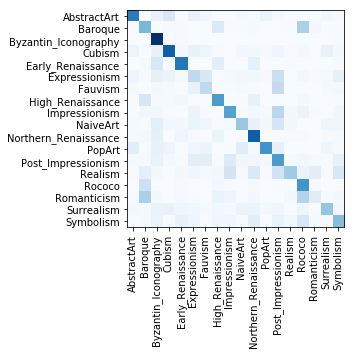

accuracy: 0.512791


In [24]:
# Matrice di confusione
cm = confusion_matrix(y_test_rp, y_pred_rp)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello 3: Densenet_basic

In [25]:
# Training set generator
train_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
train_generator_db = train_datagen_db.flow_from_directory(
        directory='./aug_train_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 13125 images belonging to 18 classes.


In [26]:
# Validate set generator
val_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
val_generator_db = val_datagen_db.flow_from_directory(
        directory='./aug_val_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4383 images belonging to 18 classes.


In [27]:
# Test set generator
test_datagen_db = kimage.ImageDataGenerator(preprocessing_function=densenet.preprocess_input)
test_generator_db = test_datagen_db.flow_from_directory(
        directory='./aug_test_1',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False,
        seed=1
)

Found 4378 images belonging to 18 classes.


### Definzione e training Modello 3

In [37]:
# Download del modello pre-allenato
base_net3 = densenet.DenseNet201(weights='imagenet', include_top=False, pooling='avg')

# Congelamento dell'80% dei layer interni
limit=int(len(base_net3.layers)*.8)
for layer in base_net3.layers[:limit]:
    layer.trainable = False
    
# Costruzione layer di specializzazione    
x = base_net3.output
pred = Dense(18, activation='softmax')(x)

# Compilazione del modello
densenet_basic = Model(inputs=base_net3.input, outputs=pred)
densenet_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definizione delle callback da utilizzare in fase di allenamento
bestmodel=ModelCheckpoint(filepath='best_weights_basic_densenet_aug.h5', 
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, save_weights_only=True, 
                          mode='auto', period=1)
earlystop=EarlyStopping(monitor='val_acc', min_delta=0, 
                        patience=6, verbose=1, mode='auto', 
                        baseline=None, restore_best_weights=True)



In [ ]:
# Training del modello
densenet_basic.fit_generator(train_generator_db, steps_per_epoch=len(train_generator_db), 
                             epochs=50, callbacks=[bestmodel, earlystop], 
                             validation_data=val_generator_db, 
                             validation_steps=len(val_generator_db), 
                             verbose=1)

In [38]:
# Shortcut per caricare i pesi prodotti dal training precedente
densenet_basic.load_weights('best_weights_basic_densenet_aug.h5')

### Valutazione Modello 3

In [39]:
# Estrazione true labels e generazione delle predizioni
y_test_db = test_generator_db.classes

y_dist_db = densenet_basic.predict_generator(test_generator_db, 
                                             steps=len(test_generator_db.filenames), 
                                             verbose=1)
y_pred_db = np.argmax(y_dist_db, axis=1)

4378/4378 [==============================] - 179s 41ms/step


In [40]:
# Report
print(classification_report(y_test_db, y_pred_db))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       262
           1       0.78      0.20      0.31       230
           2       0.62      0.95      0.75       234
           3       0.60      0.76      0.67       297
           4       0.66      0.83      0.74       250
           5       0.39      0.45      0.42       234
           6       0.35      0.64      0.46       154
           7       0.69      0.61      0.65       209
           8       0.70      0.41      0.52       258
           9       0.67      0.51      0.58       231
          10       0.63      0.71      0.67       250
          11       0.95      0.34      0.50       273
          12       0.41      0.40      0.40       288
          13       0.67      0.52      0.59       322
          14       0.51      0.76      0.61       204
          15       0.56      0.45      0.50       220
          16       0.64      0.41      0.50       216
          17       0.39    

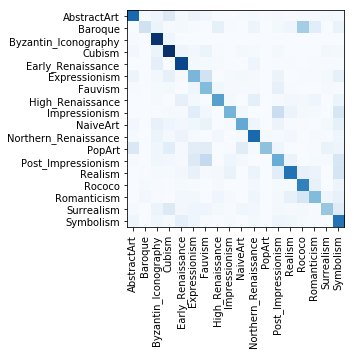

accuracy: 0.569667


In [41]:
# Matrice di confusione
cm = confusion_matrix(y_test_db, y_pred_db)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Modello Ensemble

In [42]:
# Retrival e combinazione degli output dei singoli modelli per ogni elemento del test set
# Costruzione dell'output del modello ensemble
y = []
for i in range(len(test_generator_rb)):
    y.append((y_dist_rb[i] + y_dist_rp[i] + y_dist_db[i])/3)

### Valutazione Modello Ensemble

In [43]:
# Estrazione true labels e generazione delle predizioni
y_real = test_generator_db.classes
y_pred = np.argmax(y, axis=1)

# Report
print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.80       262
           1       0.57      0.41      0.47       230
           2       0.65      1.00      0.79       234
           3       0.71      0.80      0.75       297
           4       0.84      0.78      0.81       250
           5       0.43      0.49      0.46       234
           6       0.54      0.55      0.55       154
           7       0.74      0.81      0.77       209
           8       0.82      0.55      0.66       258
           9       0.80      0.50      0.62       231
          10       0.79      0.83      0.81       250
          11       0.98      0.52      0.68       273
          12       0.41      0.60      0.49       288
          13       0.86      0.49      0.62       322
          14       0.49      0.89      0.63       204
          15       0.60      0.50      0.55       220
          16       0.74      0.56      0.64       216
          17       0.62    

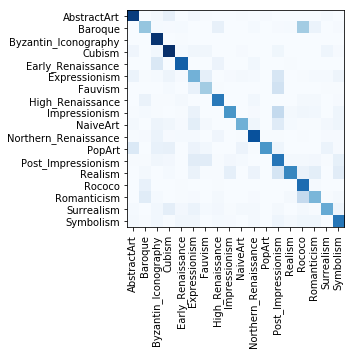

accuracy: 0.657606


In [44]:
# Matrice di confusione
cm = confusion_matrix(y_real, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.yticks(range(0,len(classes)),classes)
plt.xticks(range(0,len(classes)),classes,rotation=90)
plt.show()
print("accuracy: %.6f" % ( cm.trace()/cm.sum() ) )

## Meta Modello Mask_var

In [45]:
# Definizione delle immagini ricombinabili tramite i chunk presenti nel test set
to_merge = ['1083AbstractArt.jpg','142AbstractArt.jpg','18AbstractArt.jpg','292AbstractArt.jpg',
            '297AbstractArt.jpg','552AbstractArt.jpg','639AbstractArt.jpg','817AbstractArt.jpg',
            '917AbstractArt.jpg','964AbstractArt.jpg','394Baroque.jpg','652Baroque.jpg','667Baroque.jpg',
            '191Byzantin_Iconography.jpg','212Byzantin_Iconography.jpg','437Byzantin_Iconography.jpg',
            '589Byzantin_Iconography.jpg','605Byzantin_Iconography.jpg','6Byzantin_Iconography.jpg',
            '811Byzantin_Iconography.jpg','1195Cubism.jpg','343Cubism.jpg','387Cubism.jpg','395Cubism.jpg',
            '505Cubism.jpg','676Cubism.jpg','997Cubism.jpg','125Early_Renaissance.jpg','131Early_Renaissance.jpg',
            '300Early_Renaissance.jpg','302Early_Renaissance.jpg','395Early_Renaissance.jpg',
            '512Early_Renaissance.jpg','549Early_Renaissance.jpg','65Early_Renaissance.jpg','21Expressionism.jpg',
            '440Expressionism.jpg','824Expressionism.jpg','194Fauvism.jpg','525Fauvism.jpg','587Fauvism.jpg',
            '416High_Renaissance.jpg','797High_Renaissance.jpg','1030Impressionism.jpg','21Impressionism.jpg',
            '414Impressionism.jpg','534Impressionism.jpg','537Impressionism.jpg','61Impressionism.jpg',
            '641Impressionism.jpg','661Impressionism.jpg','822Impressionism.jpg','914Impressionism.jpg',
            '986Impressionism.jpg','991Impressionism.jpg','249NaiveArt.jpg','302NaiveArt.jpg','312NaiveArt.jpg',
            '417NaiveArt.jpg','545NaiveArt.jpg','762NaiveArt.jpg','898NaiveArt.jpg','151Northern_Renaissance.jpg',
            '191Northern_Renaissance.jpg','564Northern_Renaissance.jpg','92Northern_Renaissance.jpg','223PopArt.jpg',
            '291PopArt.jpg','325PopArt.jpg','357PopArt.jpg','490PopArt.jpg','579PopArt.jpg','581PopArt.jpg',
            '756PopArt.jpg','845PopArt.jpg','954PopArt.jpg','1213Post_Impressionism.jpg','1225Post_Impressionism.jpg',
            '371Post_Impressionism.jpg','411Post_Impressionism.jpg','454Post_Impressionism.jpg','1036Realism.jpg',
            '1075Realism.jpg','1145Realism.jpg','120Realism.jpg','306Realism.jpg','331Realism.jpg','39Realism.jpg',
            '563Realism.jpg','72Realism.jpg','783Realism.jpg','849Realism.jpg','914Realism.jpg','953Realism.jpg',
            '958Realism.jpg','12Rococo.jpg','225Rococo.jpg','52Rococo.jpg','641Rococo.jpg','379Romanticism.jpg',
            '462Romanticism.jpg','473Romanticism.jpg','487Romanticism.jpg','543Romanticism.jpg','249Surrealism.jpg',
            '771Surrealism.jpg','253Symbolism.jpg','326Symbolism.jpg','454Symbolism.jpg','485Symbolism.jpg',
            '543Symbolism.jpg','610Symbolism.jpg','657Symbolism.jpg','741Symbolism.jpg','757Symbolism.jpg',
            '771Symbolism.jpg','822Symbolism.jpg','830Symbolism.jpg','93Symbolism.jpg']
print("loaded %s chunked test file to merge" % len(to_merge))

loaded 119 chunked test file to merge


In [47]:
# Verifica dell'accuracy sui chunk di cui sopra
d = {'predicted':y_pred, 'real':y_real, 'file': test_generator_rb.filenames}
comb = pd.DataFrame(d)
comb['file']=comb['file'].str.replace(r'\w+\\', r'')
comb['file']=comb['file'].str.replace(r'_\d+', r'')
comb['result']=comb['predicted'] == comb['real']

print("Chunked accuracy: %.3f" % (comb['result'].sum()/len(comb['result'])))

Chunked accuracy: 0.658


In [50]:
# Ricombinazione delle predizioni sui singoli chunk per la 
#classificazione delle singole immagini
indexes=[]
for i in range(0,len(comb['file'])):
    if comb['file'][i] in to_merge:
        indexes.append(i)
index2 = list((set(list(range(0, len(comb['file'])))) - set(indexes)))
comb=comb.drop(comb.index[index2])
assert all([f in to_merge for f in comb['file']])
prob = pd.DataFrame(np.row_stack(y))
combo_all = comb.join(prob, how='inner')
combo_all.drop(['result','predicted'], axis = 1, inplace=True)
combo_all=combo_all.groupby('file').mean()
combo_all['predicted'] = combo_all[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]].idxmax(axis=1)
combo_all['score'] = combo_all['real'] == combo_all['predicted']

In [51]:
combo_all['score'].mean()

0.6890756302521008